In [1]:
# Step 0. Load libraries and custom modules ----------------------------
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Statistical tools ----------------------------------------------------
from scipy.stats import boxcox
# Machine learning -----------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
# Metrics --------------------------------------------------------------
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# This dataset comes from this paper:
# https://bmcbioinformatics.biomedcentral.com/track/pdf/10.1186/1471-2105-8-340.pdf
# It's about image segmentation on a breast carcinoma (SKBR3) where 
# images are classified as well segmented WS and poor segmented PS for
# the exploration of cellular signalling and morphology 

# Step 1. Read the dataset
df_raw = pd.read_csv('data/raw/skbr_cells.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Cell                     2019 non-null   int64  
 1   Case                     2019 non-null   object 
 2   Class                    2019 non-null   object 
 3   AngleCh1                 2019 non-null   float64
 4   AreaCh1                  2019 non-null   int64  
 5   AvgIntenCh1              2019 non-null   float64
 6   AvgIntenCh2              2019 non-null   float64
 7   AvgIntenCh3              2019 non-null   float64
 8   AvgIntenCh4              2019 non-null   float64
 9   ConvexHullAreaRatioCh1   2019 non-null   float64
 10  ConvexHullPerimRatioCh1  2019 non-null   float64
 11  DiffIntenDensityCh1      2019 non-null   float64
 12  DiffIntenDensityCh3      2019 non-null   float64
 13  DiffIntenDensityCh4      2019 non-null   float64
 14  EntropyIntenCh1         

In [3]:
# Step 2. Make required transformations
df_interim = df_raw[['EqSphereAreaCh1','PerimCh1','Class','Case']].copy()

In [4]:
# Step 3. Analyze data
df_train = df_interim[df_interim.Case=='Train'].drop('Case', axis=1)
df_test = df_interim[df_interim.Case=='Train'].drop('Case', axis=1)

In [5]:
# 3.1 Describe data
df_train.describe()

,EqSphereAreaCh1,PerimCh1
count,1009.000000,1009.000000
mean,1302.497250,91.606820
std,866.220998,41.962245
min,603.755102,47.737594
25%,779.850340,64.366964
50%,1027.222222,79.021475
75%,1505.195011,103.241588
max,8746.063492,459.765378


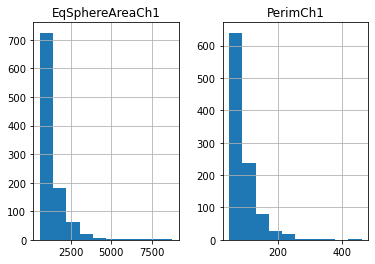

In [6]:
df_train.hist()
plt.show()

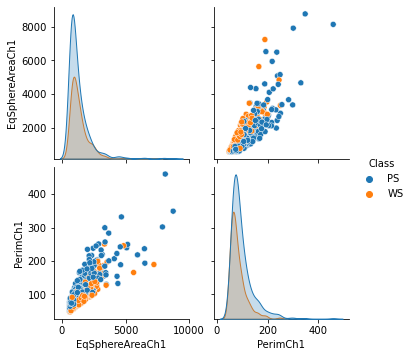

In [7]:
sns.pairplot(data=df_train, hue='Class')
plt.show()

In [8]:
# Calculate lambda coefficients in the BoxCox power transformation
_, lb_EqSphereAreaCh1 = boxcox(df_train.EqSphereAreaCh1)
_, lb_PerimCh1 = boxcox(df_train.PerimCh1)
print(f'Lambda for EqSphereAreaCh1: {lb_EqSphereAreaCh1:.3f}')
print(f'Lambda for PerimCh1: {lb_PerimCh1:.3f}')

Lambda for EqSphereAreaCh1: -0.857
Lambda for PerimCh1: -1.091


In [9]:
# Apply the transformation on a temporal dataframe
df_train_tf = df_train.copy()
df_train_tf['EqSphereAreaCh1'] = np.\
    power(df_train_tf.EqSphereAreaCh1, lb_EqSphereAreaCh1)
df_train_tf['PerimCh1'] = np.\
    power(df_train_tf.PerimCh1, lb_PerimCh1)

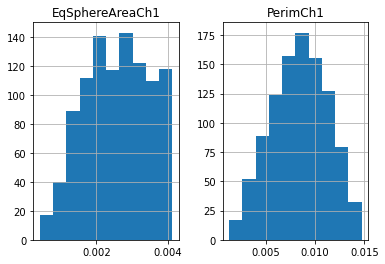

In [10]:
# Let's visualize the effect of the transformation on a histogram
df_train_tf.hist()
plt.show()

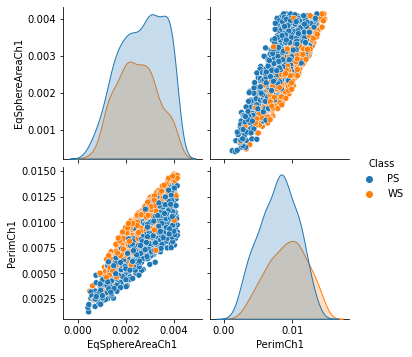

In [11]:
# Let's make a pairplot to see the effect on the class separation
sns.pairplot(data=df_train_tf, hue='Class')
plt.show()

In [30]:
# Step 4. Create a model
# 4.1 Split the dataset accordingly
X_train = df_train[['EqSphereAreaCh1','PerimCh1']]
X_test = df_test[['EqSphereAreaCh1','PerimCh1']]
y_train = df_train['Class']
y_test = df_test['Class']

In [31]:
# 4.2.1 Create a pipeline with the untransformed data and apply LR
model_ulr = Pipeline([
    ('scaler',MinMaxScaler()),
    ('classifier',LogisticRegression(class_weight='balanced'))
])

In [32]:
# 4.2.2 Fit the model and evaluate the metrics on the training set
model_ulr.fit(X_train, y_train)
print(f'Accuracy in train set: {model_ulr.score(X_train, y_train): .4f}')

Accuracy in train set:  0.6630


              precision    recall  f1-score   support

          PS       0.85      0.57      0.68       636
          WS       0.53      0.83      0.64       373

    accuracy                           0.66      1009
   macro avg       0.69      0.70      0.66      1009
weighted avg       0.73      0.66      0.67      1009



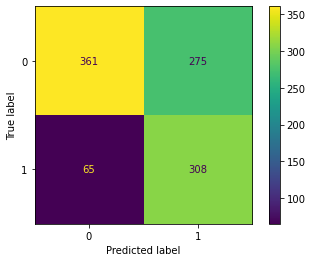

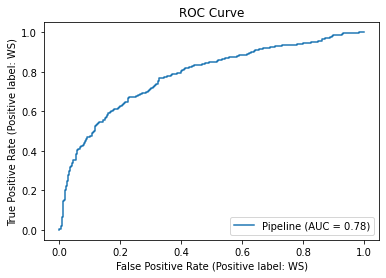

In [37]:
# 4.2.3 Predict and evaluate metrics on the test set
y_pred = model_ulr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
RocCurveDisplay.from_estimator(model_ulr, X_test, y_test)
plt.title('ROC Curve')
plt.show()

In [34]:
# 4.3.1 Create a pipeline with the transformed data and apply LR
model_lr = Pipeline([
    ('boxcox',PowerTransformer(method='box-cox')),
    ('classifier',LogisticRegression(class_weight='balanced'))
])

In [35]:
# 4.3.2 Fit the model and evaluate the metrics on the training set
model_lr.fit(X_train, y_train)
print(f'Accuracy in train set: {model_lr.score(X_train, y_train): .4f}')

Accuracy in train set:  0.7532


              precision    recall  f1-score   support

          PS       0.86      0.73      0.79       636
          WS       0.63      0.80      0.70       373

    accuracy                           0.75      1009
   macro avg       0.75      0.76      0.75      1009
weighted avg       0.78      0.75      0.76      1009



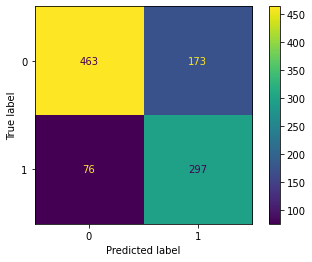

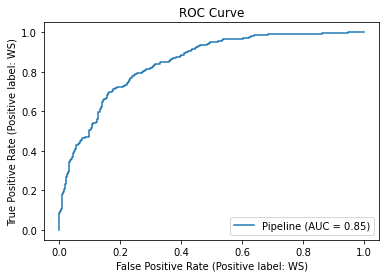

In [36]:
# 4.3.3 Predict and evaluate metrics on the test set
y_pred = model_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
RocCurveDisplay.from_estimator(model_lr, X_test, y_test)
plt.title('ROC Curve')
plt.show()

In [ ]:
# Further reading
# http://www.feat.engineering/index.html
# https://www.geeksforgeeks.org/box-cox-transformation-using-python/
# Lambdas: https://www.statisticshowto.com/probability-and-statistics/normal-distributions/box-cox-transformation/